In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/FakeNews/

/content/drive/MyDrive/FakeNews


# FakeLenseV2o (Advanced version)

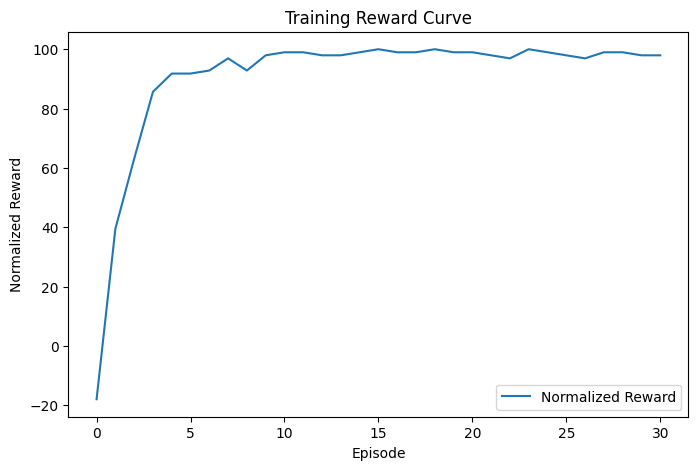

<ipython-input-3-fc4dc0fcaa07>:317: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.agent.model.load_state_dict(torch.load('./models/best_model.pth', map_location=self.ag


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



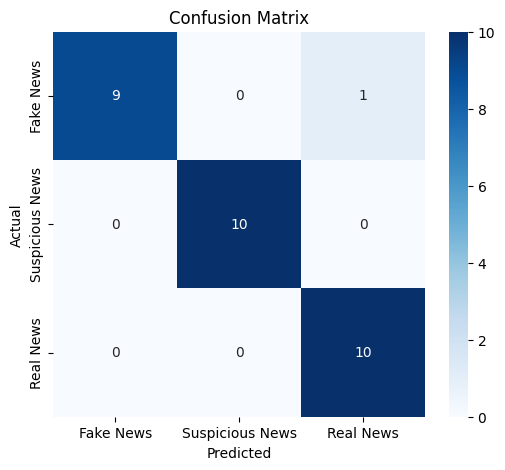

In [3]:
import os
import json
import random
import logging
from collections import deque
from typing import Any, Dict, List, Tuple, Union
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from transformers import BertTokenizer, BertModel, RobertaTokenizer, RobertaModel

# Logging configuration
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


# ==========================================
# STEP 0: Text Vectorization (BERT/RoBERTa)
# ==========================================
class BaseVectorizer:
    """
    Base template for a vectorizer class.
    Converts input text into vectors using pre-trained models like BERT or RoBERTa.
    """
    def __init__(self, model_name: str = "bert-base-uncased"):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model = BertModel.from_pretrained(model_name).to(self.device)

    def vectorize(self, text: Union[str, List[str]], pooling: bool = False) -> Union[np.ndarray, torch.Tensor]:
        """
        Vectorize the given text.
        :param text: A single string or a list of strings.
        :param pooling: Whether to apply mean pooling over the last hidden states.
        :return: Text vector (numpy array or torch.Tensor)
        """
        inputs = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(self.device)
        with torch.no_grad():
            outputs = self.model(**inputs)
        if pooling:
            return outputs.last_hidden_state.mean(dim=1).cpu()
        # Use the [CLS] token's vector
        result = outputs.last_hidden_state[:, 0, :]
        if isinstance(text, list):
            return result.cpu().numpy()
        else:
            return result.squeeze().cpu().numpy()


# ===========================
# STEP 1: Feature Extraction
# ===========================
class FeatureExtractor:
    """
    Combines text, media reliability, and social reactions metadata into a feature vector.
    """
    def __init__(self, vectorizer: BaseVectorizer = None):
        # Default to using the BERT vectorizer (can be replaced with RoBERTa, etc. if needed)
        self.vectorizer = vectorizer if vectorizer is not None else BaseVectorizer()

    @staticmethod
    def convert_source_reliability(source_reliability: str) -> float:
        """
        Convert media source reliability into a numerical score (float).
        Reliability mapping: Actual reliability score based on the media source.
        """
        reliability_mapping = {
            "The New York Times": 0.90,
            "The Washington Post": 0.85,
            "CNN": 0.80,
            "BBC": 0.85,
            "NPR": 0.90,
            "Reuters": 0.90,
            "The Wall Street Journal": 0.85,
            "USA Today": 0.75,
            "Fox News": 0.60,
            "Bloomberg": 0.85,
            "The Guardian": 0.80,
            "Los Angeles Times": 0.80,
            "New York Post": 0.60,
            "HuffPost": 0.70,
            "Associated Press": 0.90
        }
        return reliability_mapping.get(source_reliability, 0.50)

    def extract_features(self, text: str, source_reliability: str, social_reactions: float) -> np.ndarray:
        """
        Combine the text vector and additional metadata (reliability, social reactions).
        :param text: Article content.
        :param source_reliability: Media source of the article.
        :param social_reactions: Number of social media reactions.
        :return: Combined feature vector (numpy array).
        """
        reliability_score = self.convert_source_reliability(source_reliability)
        text_vector = self.vectorizer.vectorize(text)
        # Normalize social reactions (e.g., divide by 10,000)
        return np.concatenate([text_vector, [reliability_score], [social_reactions / 10000]], axis=0)


# ================================================
# STEP 2: DQN and Enhanced Neural Network Models
# ================================================
class DQN(nn.Module):
    """
    Basic Deep Q-Network (DQN) model.
    """
    def __init__(self, input_dim: int, output_dim: int):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


class DQNResidual(nn.Module):
    """
    Enhanced DQN model with Residual Connection, Layer Normalization, and Dropout.
    """
    def __init__(self, input_dim: int, output_dim: int, dropout: float = 0.2):
        super(DQNResidual, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.ln1 = nn.LayerNorm(256)
        self.dropout1 = nn.Dropout(dropout)

        self.fc2 = nn.Linear(256, 128)
        self.ln2 = nn.LayerNorm(128)
        self.dropout2 = nn.Dropout(dropout)

        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, output_dim)
        # Linear layer for residual connection (from input dimension to 64)
        self.residual_fc = nn.Linear(input_dim, 64)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        residual = self.residual_fc(x if x.dim() == 2 else x.unsqueeze(0))
        x = F.relu(self.ln1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.ln2(self.fc2(x)))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x) + residual)  # Add residual connection
        return self.fc4(x)


# =======================================================
# STEP 3: Reinforcement Learning Agent (Fake News Agent)
# =======================================================
class FakeNewsAgent:
    """
    Reinforcement learning-based agent for fake news detection.
    Incorporates techniques such as Double DQN, Target Network Smoothing, and Reward Shaping.
    """
    def __init__(self, state_size: int, action_size: int, config: Dict[str, Any]):
        self.state_size = state_size
        self.action_size = action_size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.memory = deque(maxlen=config.get("memory_size", 2000))
        # Select basic DQN or Residual DQN based on configuration
        use_residual = config.get("use_residual", False)
        if use_residual:
            self.model = DQNResidual(state_size, action_size).to(self.device)
            self.target_model = DQNResidual(state_size, action_size).to(self.device)
        else:
            self.model = DQN(state_size, action_size).to(self.device)
            self.target_model = DQN(state_size, action_size).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=config.get("learning_rate", 0.0005))
        self.criterion = nn.MSELoss()
        self.batch_size = config.get("batch_size", 64)
        self.gamma = config.get("gamma", 0.99)
        self.epsilon = config.get("epsilon", 1.0)
        self.epsilon_decay = config.get("epsilon_decay", 0.995)
        self.epsilon_min = config.get("epsilon_min", 0.01)
        self.update_target_freq = config.get("update_target_freq", 10)
        self.step_count = 0
        self.tau = config.get("tau", 0.005)  # Target Network Smoothing

    def remember(self, state: np.ndarray, action: int, reward: float, next_state: np.ndarray, done: bool) -> None:
        # Store transition in replay memory
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state: Union[np.ndarray, torch.Tensor]) -> int:
        # ε-greedy action selection
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        if isinstance(state, np.ndarray):
            state = torch.FloatTensor(state).to(self.device)
        q_values = self.model(state if state.dim() == 2 else state.unsqueeze(0))
        return int(torch.argmax(q_values).item())

    def replay(self) -> None:
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.FloatTensor(states).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        # Double DQN update
        q_values = self.model(states)
        next_q_values = self.model(next_states)
        next_q_target = self.target_model(next_states).detach()

        q_target = q_values.clone()
        for i in range(self.batch_size):
            if dones[i]:
                q_target[i, actions[i]] = rewards[i]
            else:
                best_action = torch.argmax(next_q_values[i]).item()
                q_target[i, actions[i]] = rewards[i] + self.gamma * next_q_target[i, best_action]

        # Reward Shaping: Apply penalty based on the agent's prediction confidence
        for i in range(self.batch_size):
            confidence = torch.max(q_values[i]).item()
            if not dones[i]:
                if torch.argmax(q_values[i]).item() != actions[i]:
                    reward_penalty = 2 * confidence
                else:
                    reward_penalty = 0.5 * confidence
                q_target[i, actions[i]] -= reward_penalty

        loss = self.criterion(q_values, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Decrease epsilon for exploration-exploitation balance
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        # Soft update the target network
        self.step_count += 1
        if self.step_count % self.update_target_freq == 0:
            self.soft_update(self.model, self.target_model)

    def soft_update(self, model: nn.Module, target_model: nn.Module) -> None:
        """
        Soft update the target network parameters.
        """
        for target_param, param in zip(target_model.parameters(), model.parameters()):
            target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)


# ================================================
# STEP 4: Trainer Class (Training and Evaluation)
# ================================================
class Trainer:
    """
    Class to manage training, validation, and evaluation of the agent.
    """
    def __init__(self, agent: FakeNewsAgent, feature_extractor: FeatureExtractor, config: Dict[str, Any]):
        self.agent = agent
        self.feature_extractor = feature_extractor
        self.config = config

    def train(self, data: List[Dict[str, Any]], num_episodes: int = 500, patience: int = 15) -> None:
        best_reward = -float("inf")
        no_improvement = 0
        max_possible_reward = len(data)
        reward_history = []

        for episode in range(num_episodes):
            total_reward = 0
            for sample in data:
                features = self.feature_extractor.extract_features(
                    sample["text"],
                    sample["source_reliability"],
                    sample["social_reactions"]
                )
                state = features
                action = self.agent.act(state)
                reward = 1 if action == sample["label"] else -1
                self.agent.remember(state, action, reward, state, False)
                self.agent.replay()
                total_reward += reward

            normalized_reward = (total_reward / max_possible_reward) * 100
            reward_history.append(normalized_reward)
            logging.info(f"Episode {episode + 1:03d} - Total Reward: {total_reward} ({normalized_reward:.2f}/100)")

            if total_reward > best_reward:
                best_reward = total_reward
                no_improvement = 0
                if not os.path.exists('models'):
                    os.makedirs('models')
                torch.save(self.agent.model.state_dict(), "./models/best_model.pth")
            else:
                no_improvement += 1
            if no_improvement >= patience:
                logging.info("Early stopping triggered.")
                break

        # Visualize training reward curve
        plt.figure(figsize=(8, 5))
        plt.plot(reward_history, label="Normalized Reward")
        plt.xlabel("Episode")
        plt.ylabel("Normalized Reward")
        plt.title("Training Reward Curve")
        plt.legend()
        plt.show()

    def infer(self, text: str, source_reliability: str, social_reactions: float) -> int:
        """
        Perform inference on a single sample.
        """
        features = self.feature_extractor.extract_features(text, source_reliability, social_reactions)
        features_tensor = torch.FloatTensor(features).unsqueeze(0).to(self.agent.device)
        self.agent.model.load_state_dict(torch.load('./models/best_model.pth', map_location=self.agent.device))
        self.agent.model.eval()
        with torch.no_grad():
            action = self.agent.act(features_tensor)
        return action

    def evaluate(self, data: List[Dict[str, Any]]) -> None:
        """
        Evaluate the agent on the test dataset and output performance metrics and a confusion matrix.
        """
        y_true = []
        y_pred = []

        logging.info("\n========== ON TEST DATASET ==========")
        for sample in data:
            prediction = self.infer(
                sample["text"],
                sample["source_reliability"],
                sample["social_reactions"]
            )
            y_true.append(sample["label"])
            y_pred.append(prediction)
            pred_str = {0: "Fake News", 1: "Suspicious News", 2: "Real News"}.get(prediction, "Unknown")
            logging.info(f"Article: {sample['text']}\nPrediction: {pred_str}\n")

        acc = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='micro')
        recall = recall_score(y_true, y_pred, average='micro')
        logging.info("\n========== Performance Metrics ==========")
        logging.info(f"Accuracy: {acc:.4f}")
        logging.info(f"Precision: {precision:.4f}")
        logging.info(f"Recall: {recall:.4f}")
        print("\nClassification Report:\n", classification_report(y_true, y_pred))

        # Visualize the confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=["Fake News", "Suspicious News", "Real News"],
                    yticklabels=["Fake News", "Suspicious News", "Real News"])
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()


# ==========================================
# STEP 5: Main Function (Execution Pipeline)
# ==========================================
def main():
    """
    Example format for training and evaluation data:
    {
        "text": "The federal government announces new regulations to ensure AI ethics in law enforcement.",
        "source_reliability": "The New York Times",
        "social_reactions": 6200,
        "label": 1
    }
    """
    # Configuration settings
    config = {
        "memory_size": 2000,
        "learning_rate": 0.0005,
        "batch_size": 64,
        "gamma": 0.99,
        "epsilon": 1.0,
        "epsilon_decay": 0.995,
        "epsilon_min": 0.01,
        "update_target_freq": 10,
        "tau": 0.005,
        "use_residual": True  # Whether to use the Residual Connection model
    }

    # Load data
    with open("./data/train_data.json", "r", encoding="utf-8") as f:
        train_data = json.load(f)
    with open("./data/test_data.json", "r", encoding="utf-8") as f:
        test_data = json.load(f)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logging.info(f"Using device: {device}")

    # Define state and action dimensions
    state_size = 768 + 2  # BERT vector dimension + (source reliability, social reactions)
    action_size = 3       # Fake, Suspicious, Real

    # Create the vectorizer and feature extractor
    vectorizer = BaseVectorizer(model_name="bert-base-uncased")
    feature_extractor = FeatureExtractor(vectorizer=vectorizer)

    # Initialize the fake news detection agent
    agent = FakeNewsAgent(state_size, action_size, config)

    # Create the trainer object
    trainer = Trainer(agent, feature_extractor, config)

    # Train the agent
    trainer.train(train_data, num_episodes=500, patience=15)

    # Evaluate the agent
    trainer.evaluate(test_data)


if __name__ == "__main__":
    main()